# Adding Memory to the LangGraph Chatbot

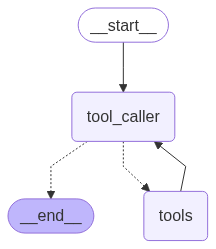

In [1]:
from typing import Annotated 
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages 

class AgentState(TypedDict):
    """Messages are of type list, and the annotation defines how the list is updated
    In this case, the add_messages reducer is telling it to append new messages to the list instead of replacing it.
    """
    messages: Annotated[list, add_messages]
    
graph = StateGraph(AgentState)



import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq

load_dotenv()  

llm = ChatGroq(
    model_name=os.getenv("MODEL_NAME"),
    api_key=os.getenv("GROQ_API_KEY") 
)

from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)

## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

tools=[tool,multiply]
llm_with_tool=llm.bind_tools(tools)

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
# build graph
graph = StateGraph(AgentState)

# define tolnodes
def tool_caller(state:AgentState) -> AgentState:
    """This node calls tools and appends the results to the messages list."""
    return {
        "messages":state["messages"] + [llm_with_tool.invoke(state["messages"])]
        }

# add nodes
graph.add_node("tool_caller", tool_caller)
graph.add_node("tools", ToolNode(tools))



# add edges conditionally
graph.add_edge(START, "tool_caller")
graph.add_conditional_edges(
    "tool_caller", 
    # if the last message in messages is a tool call, go to tools node
    tools_condition,
    # if the last message is not a tool call, go to END node
    END
)
graph.add_edge("tools", "tool_caller")

# compile graph
app = graph.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [2]:
response=app.invoke({"messages":"Hi, my name is Dhruv"})

for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi, my name is Dhruv
================================== Ai Message ==================================

Nice to meet you, Dhruv! What brings you here today?


In [3]:
response=app.invoke({"messages":"What's my name?"})

for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

What's my name?
================================== Ai Message ==================================

/tool-use>
{
  "tool_calls": [
    {
      "id": "pending",
      "type": "function",
      "function": {
        "name": "get_name"
      },
      "parameters": {
        "user_input": "What's my name?"
      }
    }
  ]
}
</tool-use>


So what happened here is that it hallucinated and thought that there was a tool bound to the llm that got usernames. It tried to make a toolcall but didn't find any such tool.

How do we go about fixing this? We can add **memory checkpoints**

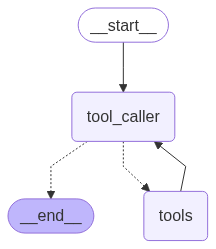

In [4]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# import memory saver to save memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# build graph
graph = StateGraph(AgentState)

# define tolnodes
def tool_caller(state:AgentState) -> AgentState:
    """This node calls tools and appends the results to the messages list."""
    return {
        "messages":state["messages"] + [llm_with_tool.invoke(state["messages"])]
        }

# add nodes
graph.add_node("tool_caller", tool_caller)
graph.add_node("tools", ToolNode(tools))



# add edges conditionally
graph.add_edge(START, "tool_caller")
graph.add_conditional_edges(
    "tool_caller", 
    # if the last message in messages is a tool call, go to tools node
    tools_condition,
    # if the last message is not a tool call, go to END node
    END
)
graph.add_edge("tools", "tool_caller")

# compile graph
app = graph.compile(checkpointer=memory) # -> have to add memory saver here

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

What the memory saver does is that it takes checkpoints each time the node is executed and stores them into a default dict.
 
These checkpoints are passed into the graph again when the graph is compiled, so the important info from the previous llm calls is preserved.

In [5]:
# you have to add a config for it to work
config = {"configurable": {"thread_id":1}}

response = app.invoke({"messages":"Hi, my name is Dhruv"}, config=config)
for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi, my name is Dhruv
================================== Ai Message ==================================

Nice to meet you, Dhruv! What brings you here today?


In [6]:
response2 = app.invoke({"messages":"What's my name?"}, config=config)
for message in response2["messages"]:   
    message.pretty_print()

================================ Human Message =================================

Hi, my name is Dhruv
================================== Ai Message ==================================

Nice to meet you, Dhruv! What brings you here today?
================================ Human Message =================================

What's my name?
================================== Ai Message ==================================

Your name is Dhruv.


As you can see, it appends to a default dict and response 2 contains both the history from previous responses and the in-context answer to the current query

# Streaming in LangGraph

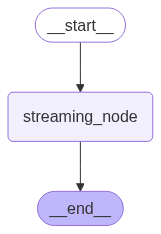

In [8]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

# create a single node graph
def streaming_node(state: AgentState) -> AgentState:
    """A simple node that streams messages."""
    return {"messages":llm.invoke(state["messages"])}

# build and compile the graph
graph = StateGraph(AgentState)
graph.add_node("streaming_node", streaming_node)
graph.add_edge(START, "streaming_node")
graph.add_edge("streaming_node", END)


app = graph.compile(checkpointer=memory)

# display graph
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

## Methods of streaming:
Theres two types of methods:
- `.stream()`: for sync streaming
- `.astream()`: for async streaming

Some additional params are:
- `values`: streams the full state of graph after each node is called -> THIS APPENDS
- `updates`: updates to the state of the graph after each node is called -> THIS REPLACES

In [13]:
config = {"configurable": {"thread_id":1}}
# stream the graph
for state in app.stream({"messages":"Hello, how are you?"}, config=config, stream_mode="values"):
    print(state)  # print the last message in the stream
    
print("\n---\n")
for state in app.stream({"messages":"Hello, how are you?"}, config=config, stream_mode="updates"):
    print(state)  # print the last message in the stream

{'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='0c9b790b-8ee5-434c-9794-be551c5919a6'), AIMessage(content="I'm just a language model, I don't have feelings or emotions like humans do, so I don't have a way to experience emotions such as happiness or sadness. However, I'm functioning properly and ready to help you with any questions or tasks you may have! How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 16, 'total_tokens': 78, 'completion_time': 0.078754942, 'prompt_time': 0.005387393, 'queue_time': 0.29710192799999996, 'total_time': 0.084142335}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'finish_reason': 'stop', 'logprobs': None}, id='run--282d1a82-80df-47e9-9b8a-4e57f61b44a7-0', usage_metadata={'input_tokens': 16, 'output_tokens': 62, 'total_tokens': 78}), HumanMessage(content='Hello, how are you?', additional_kwargs={},

Let's try a different query in a new thread_id

In [14]:
config = {"configurable": {"thread_id":5}}


for state in app.stream({"messages":"Hello, my name is Dhruv and one of the games I really like is poker. I will tell you the other ones later."}, config=config, stream_mode="updates"):
    print(state)  

{'streaming_node': {'messages': AIMessage(content="Nice to meet you, Dhruv! Poker is a great game, very strategic and exciting. I'm looking forward to hearing about the other games you enjoy playing. Go ahead and share them with me!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 38, 'total_tokens': 81, 'completion_time': 0.054535358, 'prompt_time': 0.005916409, 'queue_time': 0.269279834, 'total_time': 0.060451767}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'finish_reason': 'stop', 'logprobs': None}, id='run--bdc399f5-1562-4377-9531-743a56a2ada8-0', usage_metadata={'input_tokens': 38, 'output_tokens': 43, 'total_tokens': 81})}}


Difference between `updates` and `values`

In [15]:
for state in app.stream({"messages":"I also like playing basketball."}, config=config, stream_mode="values"):
    print(state)  

{'messages': [HumanMessage(content='Hello, my name is Dhruv and one of the games I really like is poker. I will tell you the other ones later.', additional_kwargs={}, response_metadata={}, id='cf79e89d-5c77-49f2-81fc-ceb9374a3e06'), AIMessage(content="Nice to meet you, Dhruv! Poker is a great game, very strategic and exciting. I'm looking forward to hearing about the other games you enjoy playing. Go ahead and share them with me!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 38, 'total_tokens': 81, 'completion_time': 0.054535358, 'prompt_time': 0.005916409, 'queue_time': 0.269279834, 'total_time': 0.060451767}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'finish_reason': 'stop', 'logprobs': None}, id='run--bdc399f5-1562-4377-9531-743a56a2ada8-0', usage_metadata={'input_tokens': 38, 'output_tokens': 43, 'total_tokens': 81}), HumanMessage(content='I also like playing basketball.', additional_kwargs={}, resp

Let's stream the graph with `updates` instead of `values` this time in the new thread

In [17]:
config = {"configurable": {"thread_id":7}}
for state in app.stream({"messages":"Hello, my name is Dhruv and one of the games I really like is poker. I will tell you the other ones later."}, config=config, stream_mode="updates"):
    print(state)  

print("\n---\n")

for state in app.stream({"messages":"I also like playing basketball."}, config=config, stream_mode="updates"):
    print(state)  

{'streaming_node': {'messages': AIMessage(content="Hello Dhruv! Nice to meet you! Poker is a great game, a classic! I'm excited to hear about your other favorite games. Go ahead and share them with me! Are you a casual player or do you play competitively?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 38, 'total_tokens': 89, 'completion_time': 0.064195682, 'prompt_time': 0.012814322, 'queue_time': 0.279196559, 'total_time': 0.077010004}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'finish_reason': 'stop', 'logprobs': None}, id='run--d6df1584-8294-48dd-befa-3cb27c22ace0-0', usage_metadata={'input_tokens': 38, 'output_tokens': 51, 'total_tokens': 89})}}

---

{'streaming_node': {'messages': AIMessage(content="Basketball is a fantastic game! Do you play recreationally with friends or are you part of a team? I'm curious to know more about your basketball experience. Are you a fan of a particular team or player

So the thing to notice here is that:
- Using `updates` doesn't append everything to the stream. It just replaces the state with the last message.
- Using `values` appends the convo history including the AI messages and stuff and makes a long stream.

Using `astream` instead of `stream`.

Basically, astream will give you a lot more detail. It contains info about each and every node being executed

In [20]:
config = {"configurable": {"thread_id":10}}

async for event in app.astream_events({"messages":"Hi, my name is Dhruv and I want to learn poker"}, config=config):
    print(event)  

{'event': 'on_chain_start', 'data': {'input': {'messages': 'Hi, my name is Dhruv and I want to learn poker'}}, 'name': 'LangGraph', 'tags': [], 'run_id': '649613e2-cf04-408b-8d12-d652e5314860', 'metadata': {'thread_id': 10}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi, my name is Dhruv and I want to learn poker', additional_kwargs={}, response_metadata={}, id='a0e5a658-674e-4d64-998f-f3d3badc51c6'), HumanMessage(content='Hi, my name is Dhruv and I want to learn poker', additional_kwargs={}, response_metadata={}, id='d092a57d-9c49-43e4-9c70-975178292bf8')]}}, 'name': 'streaming_node', 'tags': ['graph:step:3'], 'run_id': '6a14d4e5-bb1b-49be-9a10-f1d2919601c2', 'metadata': {'thread_id': 10, 'langgraph_step': 3, 'langgraph_node': 'streaming_node', 'langgraph_triggers': ('branch:to:streaming_node',), 'langgraph_path': ('__pregel_pull', 'streaming_node'), 'langgraph_checkpoint_ns': 'streaming_node:9be6d5b8-8bbc-303c-d5ef-f0c29c02599c